The competition dataset is based on the [2016 NYC Yellow Cab trip record data](https://cloud.google.com/bigquery/public-data) made available in Big Query on Google Cloud Platform. The data was originally published by the [NYC Taxi and Limousine Commission (TLC)](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.

In [18]:
import warnings
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

warnings.filterwarnings("ignore")

In [19]:
train_path = os.path.join('Datasets', 'nyc_taxi', 'train.csv')
test_path = os.path.join('Datasets', 'nyc_taxi', 'test.csv')

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])

train_df = train_df.sample(frac=1)

In [20]:
print('Shape (train):', train_df.shape)
print('Shape (test):', test_df.shape)

train_df.head()

Shape (train): (1458644, 11)
Shape (test): (625134, 9)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
669791,id2571149,1,2016-05-16 13:05:03,2016-05-16 13:15:04,1,-73.967896,40.800346,-73.951561,40.824635,N,601
219180,id0764021,2,2016-05-19 13:16:00,2016-05-19 13:18:37,2,-74.000343,40.753078,-74.002350,40.756023,N,157
1148589,id0162708,2,2016-01-17 09:45:32,2016-01-17 09:50:00,1,-73.838432,40.719200,-73.850349,40.725151,N,268
856891,id0926236,1,2016-01-01 02:46:37,2016-01-01 03:01:48,2,-73.983864,40.746960,-73.934837,40.756950,N,911
496554,id3429008,1,2016-05-13 16:59:50,2016-05-13 17:38:01,1,-73.983017,40.773304,-73.982018,40.727798,N,2291


Data fields

* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

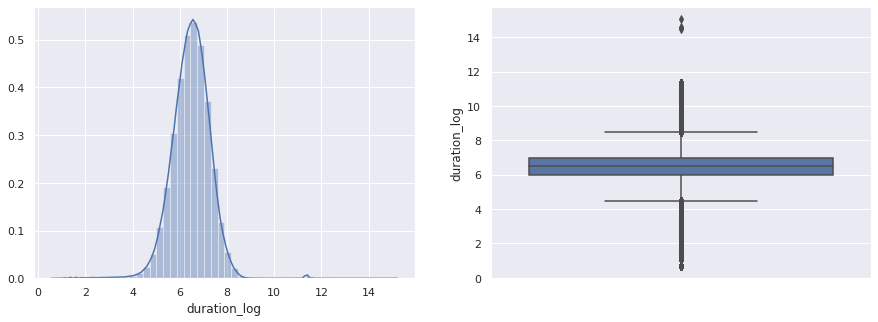

In [21]:
train_df['duration_log'] = np.log1p(train_df['trip_duration'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(train_df['duration_log'], ax=ax1)
sns.boxplot(y='duration_log', data=train_df, ax=ax2)

### Removing outliers

In [22]:
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low_b = q1 - 1.5 * iqr
    high_b = q3 + 1.5 * iqr
    mask = ((df[col] >= low_b)
            & (df[col] <= high_b))
    df = df.loc[mask]
    return df

In [23]:
train_df = remove_outliers(train_df, 'duration_log')

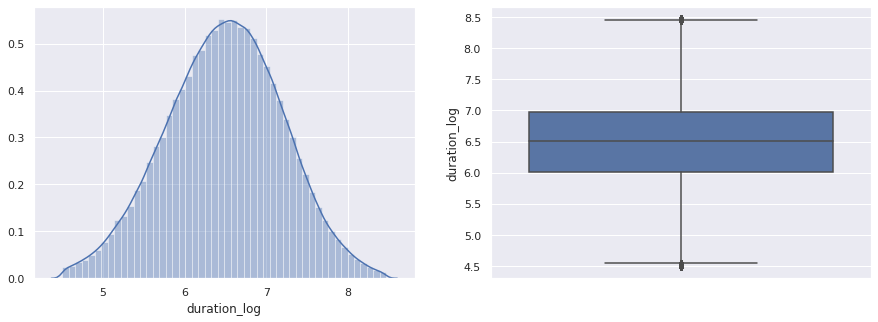

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(train_df['duration_log'], ax=ax1)
sns.boxplot(y='duration_log', data=train_df, ax=ax2)

In [25]:
geo_cols = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude']
for col in geo_cols:
    train_df = remove_outliers(train_df, col)

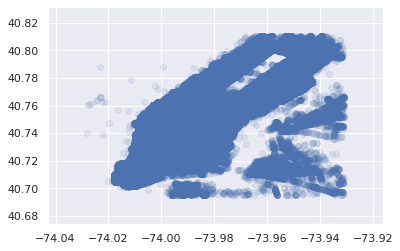

In [26]:
n = 3_000

plt.scatter(train_df.loc[:n, 'pickup_longitude'], train_df.loc[:n, 'pickup_latitude'],
            alpha=0.1)

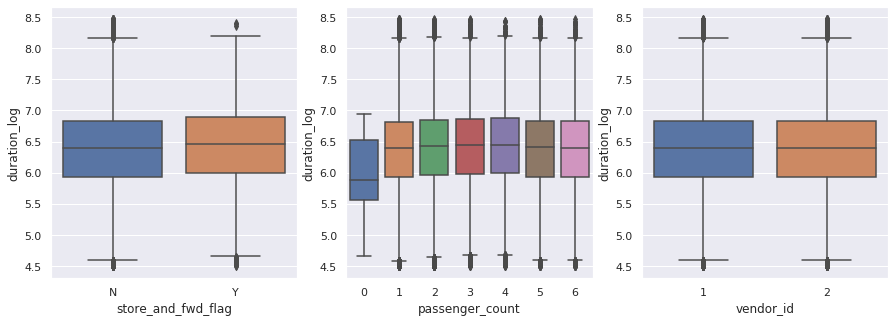

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
cols = ['store_and_fwd_flag', 'passenger_count', 'vendor_id']
for col, ax in zip(cols, axes):
    sns.boxplot(x=col, y='duration_log', data=train_df, ax=ax)

In [28]:
def get_distance(row):
    long_diff = row['dropoff_longitude'] - row['pickup_longitude']
    lati_diff = row['dropoff_latitude'] - row['pickup_latitude']
    dist = long_diff ** 2 + lati_diff ** 2
    return np.sqrt(dist)

train_df['distance'] = train_df.apply(get_distance, axis=1)

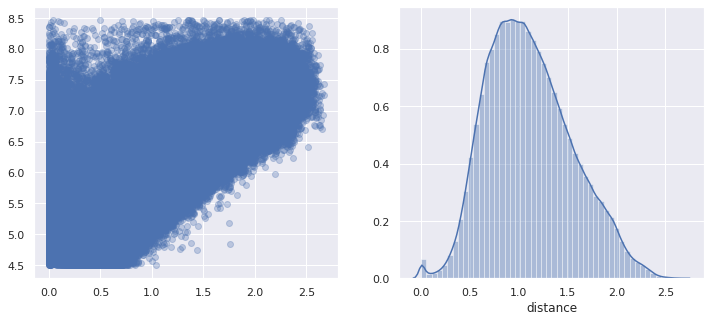

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(np.log1p(train_df.loc[:n, 'distance'] * 100), 
              train_df.loc[:n, 'duration_log'], alpha=0.3)
sns.distplot(np.log1p(train_df['distance'] * 100), ax=ax[1])

### Dates and time

In [35]:
train_df['pickup_date'] = train_df['pickup_datetime'].dt.date
train_df['pickup_time'] = train_df['pickup_datetime'].dt.time

train_df['pickup_year'] = train_df['pickup_datetime'].dt.year
train_df['pickup_month'] = train_df['pickup_datetime'].dt.month
train_df['pickup_weekday'] = train_df['pickup_datetime'].dt.weekday

train_df['pickup_hour'] = train_df['pickup_datetime'].dt.hour